In [184]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ortools.linear_solver import pywraplp
from ortools.linear_solver.pywraplp import Variable
from babel.numbers import format_currency

In [185]:
produto_dados = {}
produto_parametro = {}
producao_produto = {}
venda_produto = {}
dia = datetime.today().weekday()

In [186]:
def solver_config(gap_limit: float = 1e-3, time_limit: int = 60000 ):
        global solver, solverParams

        solver = pywraplp.Solver('hello_program', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        solver.EnableOutput()
        solver.SetTimeLimit(time_limit)
        solverParams = pywraplp.MPSolverParameters()
        solverParams.SetDoubleParam(solverParams.RELATIVE_MIP_GAP, gap_limit)

        return solver, solverParams

In [187]:
dados_produtos = pd.read_csv('dados_produtos.csv', delimiter=',')
parametros_produtos = pd.read_csv('parametros_produtos.csv', delimiter=',')

In [188]:
def obter_dados():
    global produto_dados

    for _, row in dados_produtos.iterrows():
        idProduto = str(row.idProduto)
    
        if idProduto not in produto_dados:
            produto_dados[idProduto] = {}
        
        produto_dados[idProduto]["data"] = row.data
        produto_dados[idProduto]["nomeProduto"] = row.nomeProduto
        produto_dados[idProduto]["qtde"] = row.qtde
        produto_dados[idProduto]["estoque_minimo"] = row.estoque_minimo
        produto_dados[idProduto]["producao_maxima"] = row.producao_maxima
        produto_dados[idProduto]["producao_minima"] = row.producao_minima
        produto_dados[idProduto]["custoUnitario"] = row.custoUnitario
        produto_dados[idProduto]["custoTotal"] = row.custoTotal
        produto_dados[idProduto]["precoVenda"] = row.precoVenda        

In [189]:
def obter_parametros():
    global produto_parametro

    for _, row in parametros_produtos.iterrows():
        dia = row.dia_semana
        if dia not in parametros_produtos:
            produto_parametro[dia] = {}

        produto_parametro[dia]["venda_maximo"] = row.venda_maximo
        produto_parametro[dia]["venda_minimo"] = row.venda_minimo
        produto_parametro[dia]["venda_minima_produto"] = int(row.venda_minima_produto)
        produto_parametro[dia]["venda_maxima_produto"] = int(row.venda_maxima_produto)

In [190]:
def variaveis_otimizacao():
    global solver, produto_dados, produto_parametro, producao_produto, venda_produto, dia
    
    for id in produto_dados:
        producao_produto[id] = solver.IntVar(produto_dados[id]["producao_minima"],produto_dados[id]["producao_maxima"],f'qtd_producao_{id}')
        
        venda_produto[id] = solver.IntVar(produto_parametro[dia]["venda_minima_produto"],produto_parametro[dia]["venda_maxima_produto"],f'qtd_venda_{id}')

In [191]:
def funcao_objetivo():
    global solver, producao_produto, produto_dados, produto_parametro

    objetivo = solver.Objective()
    for id in produto_dados:
        lucro_unidade = produto_dados[id]["precoVenda"] - produto_dados[id]["custoUnitario"]
        objetivo.SetCoefficient(venda_produto[id],lucro_unidade)
    
    objetivo.SetMaximization()

In [192]:
def regras_otimizacao():
    global solver, produto_dados, produto_parametro, dia

    for id in produto_dados:
        #Restrição de venda menor que produção
        solver.Add(venda_produto[id] <= producao_produto[id])
        #Restrição de produção máxima
        solver.Add(producao_produto[id] <= produto_dados[id]["producao_maxima"])
        #Restrição de produção mínima
        solver.Add(producao_produto[id] >= produto_dados[id]["producao_minima"])   
        #Restrição estoque mínimo dia seguinte
        solver.Add((producao_produto[id] - venda_produto[id]) == produto_dados[id]["estoque_minimo"])     
        
    #Restrição de venda máxima
    solver.Add(sum(venda_produto[id] for id in produto_dados) <= produto_parametro[dia]["venda_maximo"])
    #Restrição de venda mínima
    solver.Add(sum(venda_produto[id] for id in produto_dados) >= produto_parametro[dia]["venda_minimo"])

In [193]:
def resolver():
    global solver, produto_dados, produto_parametro, producao_produto,venda_produto, dia

    info = []

    status = solver.Solve(solverParams)
    for id in produto_dados:
        if(status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE):
            receita = 0
            custos = 0
            lucro = 0
            for id in produto_dados:
                producao = producao_produto[id].solution_value()
                venda = venda_produto[id].solution_value()
                estoque = producao - venda
                print(f'Produção de {produto_dados[id]["nomeProduto"]}: {producao}\tUnidades vendidas: {venda}\tUnidades em estoque: {estoque}')
                receita += venda * produto_dados[id]["precoVenda"]
                custos += producao * produto_dados[id]["custoUnitario"]
                lucro += receita - custos                
                info.append([
                    id,
                    produto_dados[id]["nomeProduto"],
                    producao,
                    venda,
                    produto_dados[id]["precoVenda"],    #Preço unitário
                    venda * produto_dados[id]["precoVenda"],    #Receita total
                    produto_dados[id]["custoUnitario"], #custo unitario
                    producao * produto_dados[id]["custoUnitario"],  #custos totais
                    (venda * produto_dados[id]["precoVenda"]) -(producao * produto_dados[id]["custoUnitario"]), #lucro
                ])
            print(f'\nReceita total: {format_currency(receita, "BRL", locale="pt_br")}')
            print(f'Custos totais: {format_currency(custos, "BRL", locale="pt_br")}')
            print(f'Lucro líquido: {format_currency(lucro, "BRL", locale="pt_br")}')
            return info
        else:
            print("Nenhuma solução encontrada!")
            return None


In [194]:
def graficos(dados):

    sns.set_style("darkgrid")

    plt.figure(figsize=(8,6))

    sns.barplot(x="Produto", y="Unidades Produzidas", data=dados, label="Produção",color="Blue",zorder=1)
    sns.barplot(x="Produto", y="Unidades Vendidas", data=dados, label="Vendas",color="Green", zorder=2)

    plt.ylim(0,2000)
    plt.xlabel("Produto", fontsize=20)
    plt.ylabel("Quantidade", fontsize=20)
    plt.legend(loc="upper left", fontsize=20)
    plt.show()
    

In [195]:
def otimizar():
    solver_config()
    obter_dados()
    obter_parametros()
    variaveis_otimizacao()
    funcao_objetivo()
    regras_otimizacao()
    
    if not isinstance(f := resolver(), type(None)):
        colunas = ["ID Produto","Produto","Unidades Produzidas","Unidades Vendidas","Preço Unitário","Receita","Custo Unitário","Custos Totais","Lucro"]
        df = pd.DataFrame(f,columns=colunas)
        df.to_csv("output.csv", sep=";", decimal=",",columns=colunas, index=False)
        graficos(df)

Produção de Produto1: 1000.0	Unidades vendidas: 750.0	Unidades em estoque: 250.0
Produção de Produto2: 1100.0	Unidades vendidas: 1000.0	Unidades em estoque: 100.0
Produção de Produto3: 830.0	Unidades vendidas: 680.0	Unidades em estoque: 150.0
Produção de Produto4: 1075.0	Unidades vendidas: 1000.0	Unidades em estoque: 75.0
Produção de Produto5: 1100.0	Unidades vendidas: 1000.0	Unidades em estoque: 100.0

Receita total: R$ 250.890,00
Custos totais: R$ 99.280,00
Lucro líquido: R$ 467.030,00


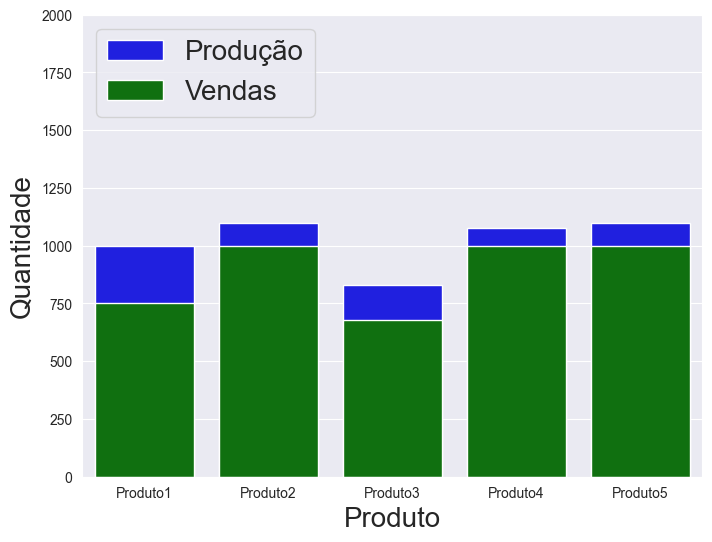

In [196]:
otimizar()